# Uniswap DEX Analysis - Data Analysis of Liquidity Providers, Transactions, and Market Activity

## Part 1: Initial Setup and Data Loading

In [45]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [47]:
# Define the data directory
data_dir = '/Users/vaish/Desktop/Uniswap-Data-Analysis/data/raw/'

In [50]:
# Load each dataset into a DataFrame
dai_eth = pd.read_csv(os.path.join(data_dir, "DAI-ETH.csv"))
eth_usdt = pd.read_csv(os.path.join(data_dir, "ETH-USDT.csv"))
uni_eth = pd.read_csv(os.path.join(data_dir, "UNI-ETH.csv"))
usdc_eth = pd.read_csv(os.path.join(data_dir, "USDC-ETH.csv"))
wbtc_eth = pd.read_csv(os.path.join(data_dir, "WBTC-ETH.csv"))
burn_mint = pd.read_csv(os.path.join(data_dir, "BurnMint.csv"))
swaps = pd.read_csv(os.path.join(data_dir, "Swaps.csv"))

## Part 2: Data Preprocessing

In [57]:
# Scale swap amounts based on token decimals
swaps['AMOUNT0_IN'] = swaps['AMOUNT0_IN'].astype(float) / np.power(10, swaps['TOKEN_0_DECIMALS'])
swaps['AMOUNT0_OUT'] = swaps['AMOUNT0_OUT'].astype(float) / np.power(10, swaps['TOKEN_0_DECIMALS'])
swaps['AMOUNT1_IN'] = swaps['AMOUNT1_IN'].astype(float) / np.power(10, swaps['TOKEN_1_DECIMALS'])
swaps['AMOUNT1_OUT'] = swaps['AMOUNT1_OUT'].astype(float) / np.power(10, swaps['TOKEN_1_DECIMALS'])

In [61]:
# Create token pairs column
swaps['token_pairs'] = swaps['TOKEN_0_TICKER_SYMBOL'] + "_" + swaps['TOKEN_1_TICKER_SYMBOL']

In [63]:
# Process burn_mint data
burn_mint['LOGGED_AMOUNT0'] = pd.to_numeric(burn_mint['LOGGED_AMOUNT0'], errors='coerce') / np.power(10, pd.to_numeric(burn_mint['TOKEN_0_DECIMALS'], errors='coerce'))
burn_mint['LOGGED_AMOUNT1'] = pd.to_numeric(burn_mint['LOGGED_AMOUNT1'], errors='coerce') / np.power(10, pd.to_numeric(burn_mint['TOKEN_1_DECIMALS'], errors='coerce'))
burn_mint['token_pairs'] = burn_mint['TOKEN_0_TICKER_SYMBOL'] + "_" + burn_mint['TOKEN_1_TICKER_SYMBOL']

In [65]:
# Convert timestamps
burn_mint['BLOCK_SIGNED_AT'] = pd.to_datetime(burn_mint['BLOCK_SIGNED_AT'])
burn_mint['BLOCK_SIGNED_AT_DAY'] = burn_mint['BLOCK_SIGNED_AT'].dt.date
swaps['BLOCK_SIGNED_AT'] = pd.to_datetime(swaps['BLOCK_SIGNED_AT'])
swaps['BLOCK_SIGNED_AT_DAY'] = swaps['BLOCK_SIGNED_AT'].dt.date

In [66]:
# Process pool data
pools = [dai_eth, eth_usdt, uni_eth, usdc_eth, wbtc_eth]
pools_str = ['dai_eth', 'eth_usdt', 'uni_eth', 'usdc_eth', 'wbtc_eth']

In [67]:
for pool in pools:
    pool['BALANCE'] = pd.to_numeric(pool['BALANCE'], errors='coerce') / np.power(10, pd.to_numeric(pool['CONTRACT_DECIMALS'], errors='coerce'))
    pool['TOTAL_SUPPLY'] = pd.to_numeric(pool['TOTAL_SUPPLY'], errors='coerce') / np.power(10, pd.to_numeric(pool['CONTRACT_DECIMALS'], errors='coerce'))
    pool['BAL/TOT_SUP'] = pool['BALANCE'] / pool['TOTAL_SUPPLY']

## Part 3: Analysis of Burns, Mints, and Swaps

In [72]:
# Combine burn_mint and swaps data
burn_mint_data = burn_mint[['token_pairs', 'EVENT_TYPE']]
swaps_data = swaps[['token_pairs', 'EVENT_TYPE']]
combined = pd.concat([burn_mint_data, swaps_data], axis=0)

In [74]:
# Calculate percentages for each event type
result = combined.groupby(['token_pairs', 'EVENT_TYPE']).size().unstack(fill_value=0)
result['BURN'] = result['BURN'] / result['BURN'].sum()
result['SWAP'] = result['SWAP'] / result['SWAP'].sum()
result['MINT'] = result['MINT'] / result['MINT'].sum()

<Figure size 1600x800 with 0 Axes>

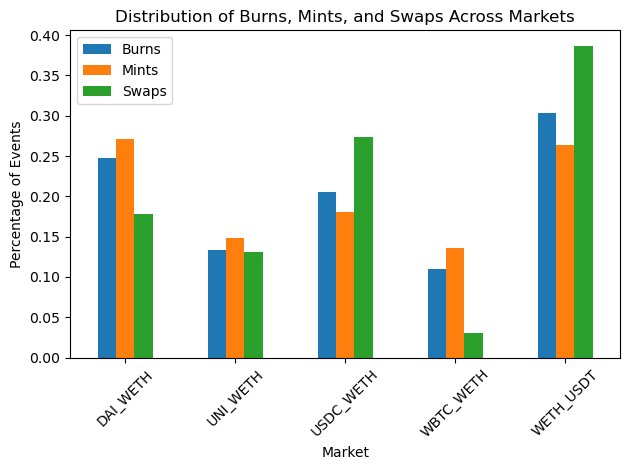

In [76]:
# Visualize event distribution
plt.figure(figsize=(16, 8))
result.plot(kind='bar', rot=45)
plt.xlabel('Market')
plt.ylabel('Percentage of Events')
plt.title('Distribution of Burns, Mints, and Swaps Across Markets')
plt.legend(['Burns', 'Mints', 'Swaps'])
plt.tight_layout()
plt.show()

## Part 4: Liquidity Provider Analysis

In [79]:
# Count LPs per pool
lp_counts = pd.DataFrame(index=pools_str, columns=['total_LPs'])
for j in range(len(pools)):
    lp_counts.iloc[j] = len(pools[j].iloc[:-1,-1])


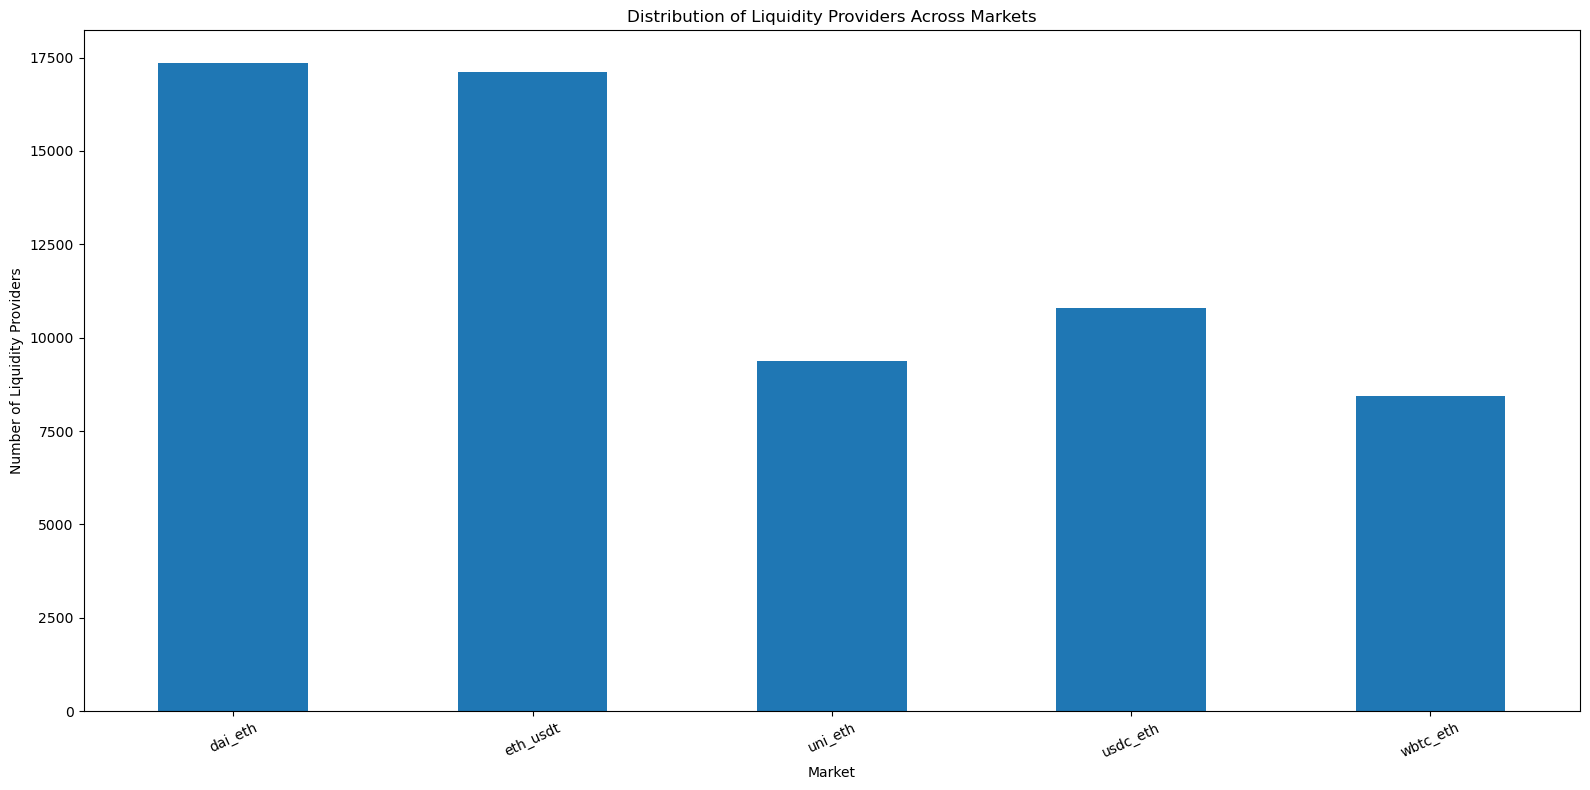

In [81]:
# Visualize LP distribution
plt.figure(figsize=(16, 8))
lp_counts['total_LPs'].plot(kind='bar', rot=25)
plt.xlabel('Market')
plt.ylabel('Number of Liquidity Providers')
plt.title('Distribution of Liquidity Providers Across Markets')
plt.tight_layout()
plt.show()


## Part 5: Top Liquidity Provider Analysis

In [87]:
# Initialize storage for top LP data
top_liq_providers = {}

# Process each pool
for j in range(len(pools)):
    # Sort by balance ratio
    sorted_data = pools[j].sort_values(by='BAL/TOT_SUP', ascending=False)
    cleaned_data = sorted_data[['ADDRESS', 'BAL/TOT_SUP']].iloc[:-1, :]
    top_5_data = cleaned_data.head(5).set_index('ADDRESS')
    top_liq_providers[pools_str[j]] = top_5_data

<Figure size 1600x800 with 0 Axes>

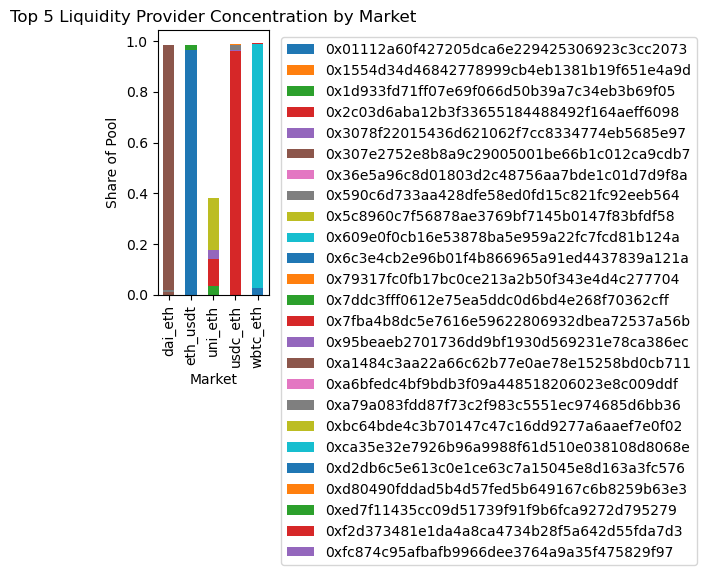

In [89]:
# Create visualization of top LP concentration
plot_data = pd.concat(top_liq_providers, axis=0).reset_index()
plot_data = plot_data.pivot(index='level_0', columns='ADDRESS', values='BAL/TOT_SUP')

plt.figure(figsize=(16, 8))
plot_data.plot(kind='bar', stacked=True)
plt.xlabel('Market')
plt.ylabel('Share of Pool')
plt.title('Top 5 Liquidity Provider Concentration by Market')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Part 6: Daily Transaction Analysis


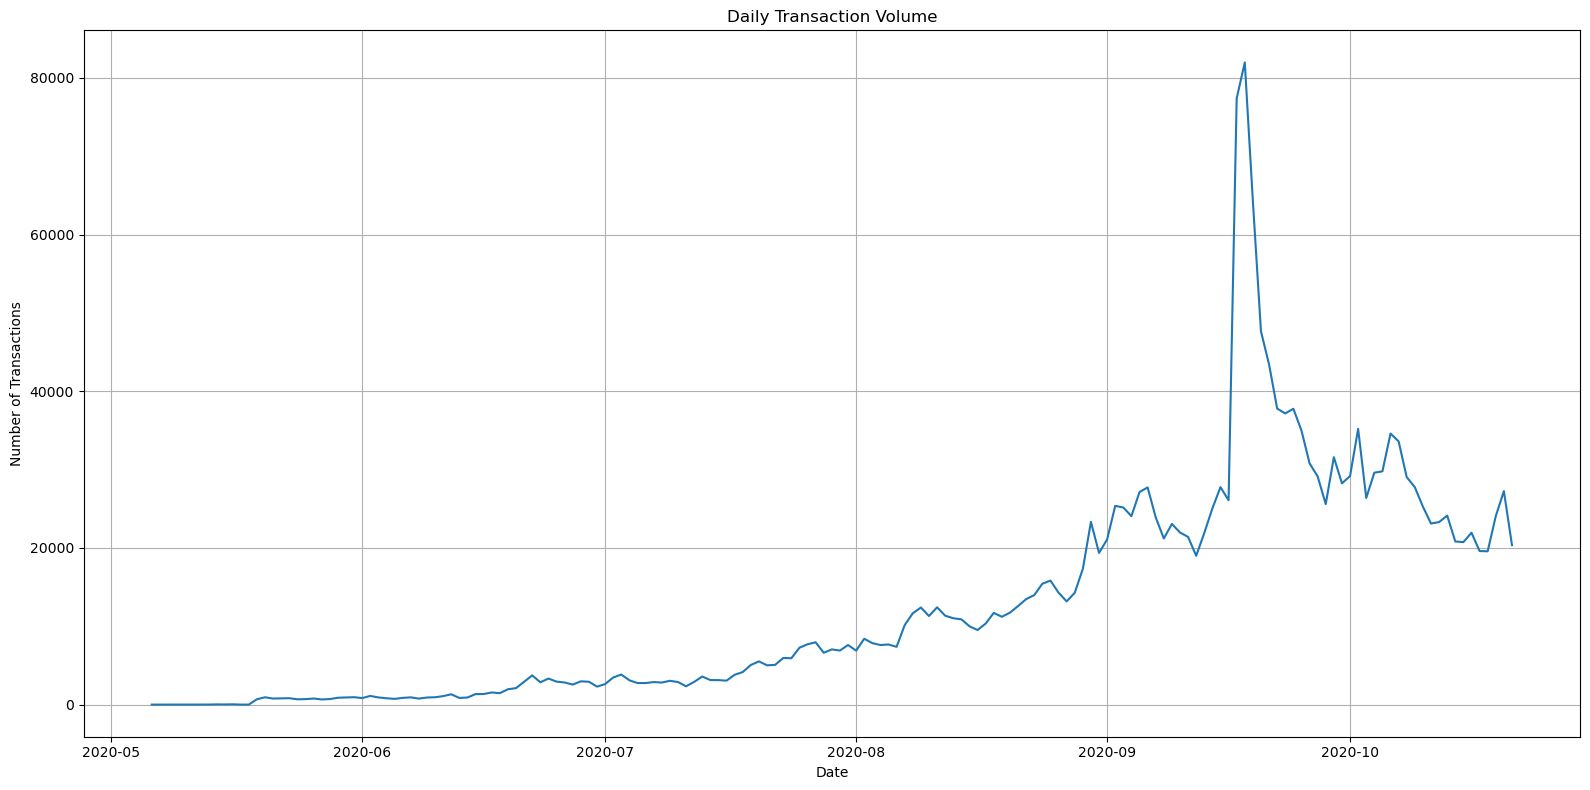

In [102]:
# Calculate daily transactions (simplified version)
burn_mint_daily = burn_mint.groupby('BLOCK_SIGNED_AT_DAY').size()
swaps_daily = swaps.groupby('BLOCK_SIGNED_AT_DAY').size()

# Combine both series
daily_transactions = pd.DataFrame({
    'burns_mints': burn_mint_daily,
    'swaps': swaps_daily
}).fillna(0)

daily_transactions['total'] = daily_transactions['burns_mints'] + daily_transactions['swaps']

# Plot daily transaction volume
plt.figure(figsize=(16, 8))
daily_transactions['total'].plot()
plt.xlabel('Date')
plt.ylabel('Number of Transactions')
plt.title('Daily Transaction Volume')
plt.grid(True)
plt.tight_layout()
plt.show()

<Figure size 1600x800 with 0 Axes>

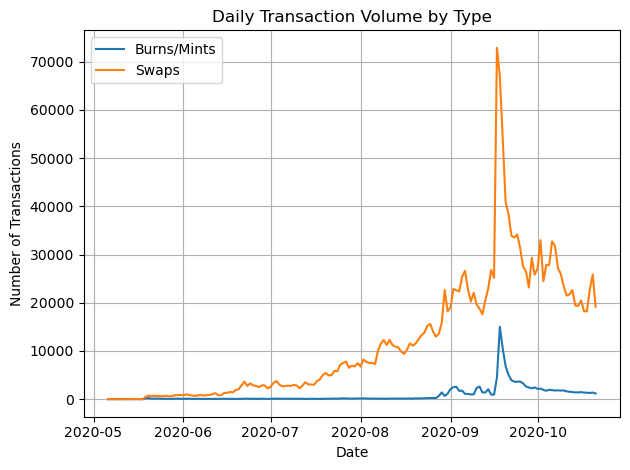

In [104]:
# Plot breakdown of transaction types
plt.figure(figsize=(16, 8))
daily_transactions[['burns_mints', 'swaps']].plot()
plt.xlabel('Date')
plt.ylabel('Number of Transactions')
plt.title('Daily Transaction Volume by Type')
plt.legend(['Burns/Mints', 'Swaps'])
plt.grid(True)
plt.tight_layout()
plt.show()

In [95]:
# Trading Volume by Pair
# Calculate total volume per pair
volume_by_pair = swaps.groupby('token_pairs').agg({
    'AMOUNT0_IN': 'sum',
    'AMOUNT1_IN': 'sum'
}).sum(axis=1)

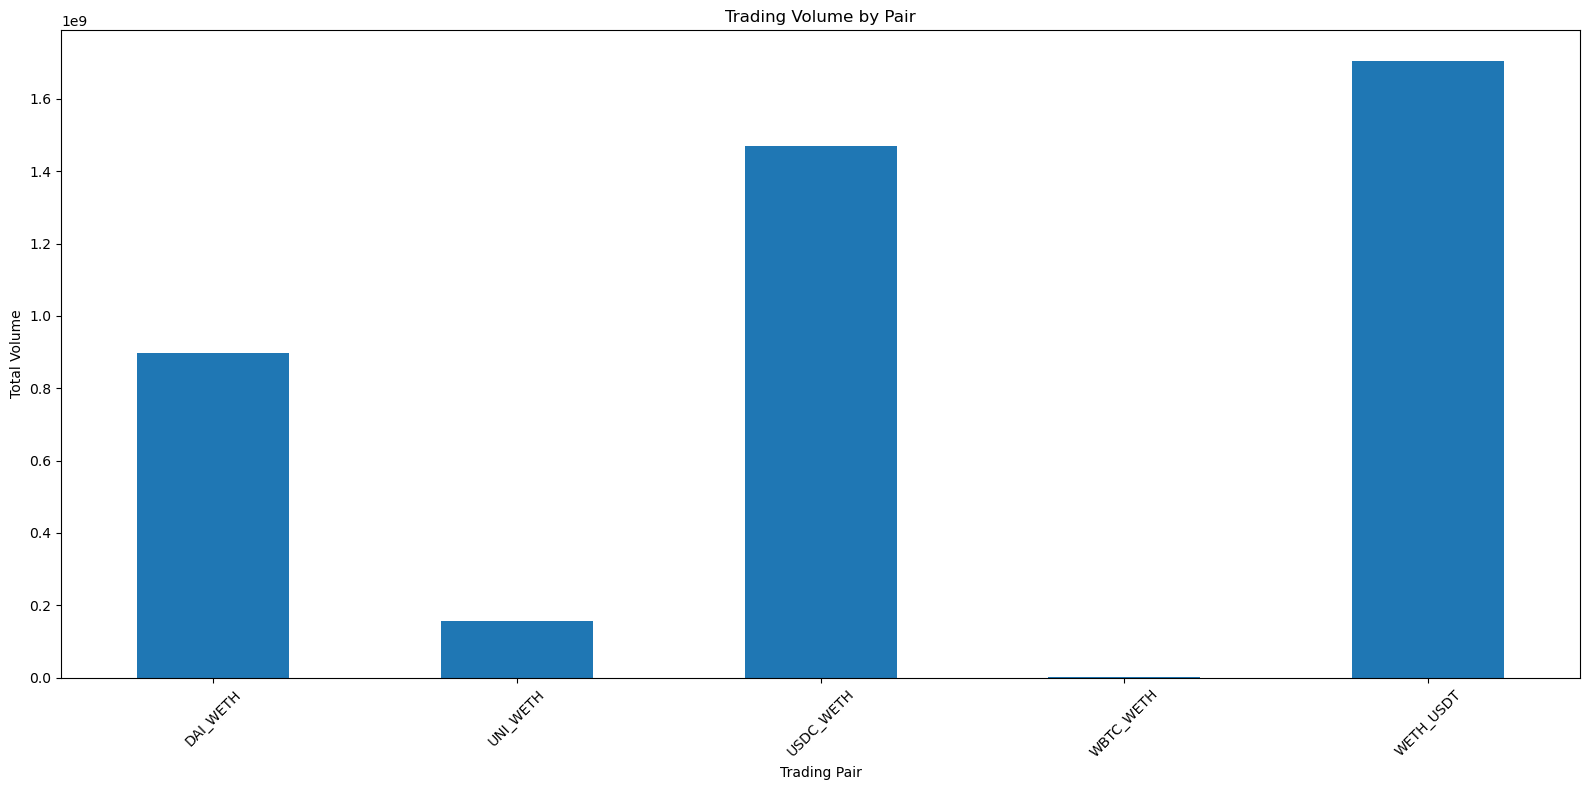

In [97]:
# Visualize volume distribution
plt.figure(figsize=(16, 8))
volume_by_pair.plot(kind='bar')
plt.xlabel('Trading Pair')
plt.ylabel('Total Volume')
plt.title('Trading Volume by Pair')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [106]:
# Print summary statistics
print("\nKey Statistics:")
print("--------------")
print(f"Total Number of Transactions: {len(swaps) + len(burn_mint):,}")
print(f"Average Daily Transactions: {daily_transactions['total'].mean():.2f}")
print(f"Maximum Daily Transactions: {daily_transactions['total'].max():.2f}")
print(f"Minimum Daily Transactions: {daily_transactions['total'].min():.2f}")
print("\nBreakdown:")
print(f"Total Swaps: {len(swaps):,}")
print(f"Total Burns/Mints: {len(burn_mint):,}")
print(f"\nDate Range: {daily_transactions.index.min()} to {daily_transactions.index.max()}")


Key Statistics:
--------------
Total Number of Transactions: 2,112,137
Average Daily Transactions: 12572.24
Maximum Daily Transactions: 81974.00
Minimum Daily Transactions: 2.00

Breakdown:
Total Swaps: 1,967,502
Total Burns/Mints: 144,635

Date Range: 2020-05-06 to 2020-10-21


In [149]:
# Volume concentration analysis
swaps['date'] = pd.to_datetime(swaps['BLOCK_SIGNED_AT_DAY'])
weekly_volume = swaps.groupby([pd.Grouper(key='date', freq='W'), 'token_pairs'])['AMOUNT0_IN'].sum()

# Calculating volume concentration
total_volume = volume_by_pair.sum()
volume_concentration = (volume_by_pair / total_volume * 100).sort_values(ascending=False)

print("\nVolume Concentration:")
print("-------------------")
for pair, concentration in volume_concentration.items():
    print(f"{pair}: {concentration:.2f}%")


Volume Concentration:
-------------------
WETH_USDT: 40.28%
USDC_WETH: 34.76%
DAI_WETH: 21.23%
UNI_WETH: 3.69%
WBTC_WETH: 0.02%


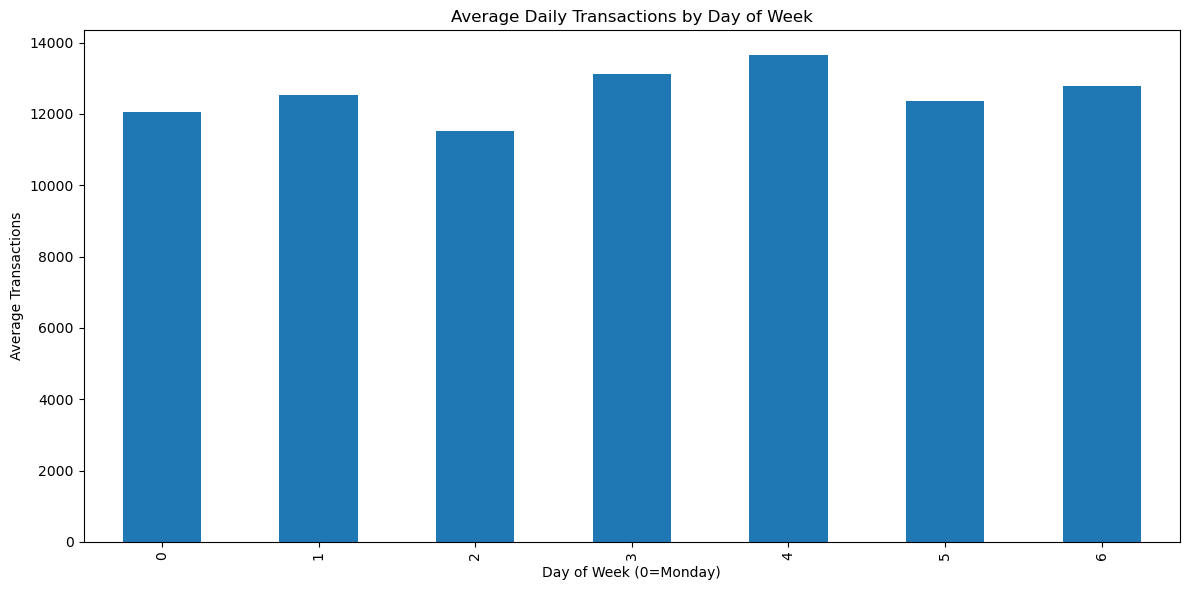


Transaction Patterns:
------------------
Most Active Day: 4 (Avg: 13660 transactions)
Least Active Day: 2 (Avg: 11532 transactions)


In [151]:
# Adding day-of-week analysis
daily_transactions['day_of_week'] = pd.to_datetime(daily_transactions.index).dayofweek
dow_stats = daily_transactions.groupby('day_of_week')['total'].mean()

plt.figure(figsize=(12, 6))
dow_stats.plot(kind='bar')
plt.title('Average Daily Transactions by Day of Week')
plt.xlabel('Day of Week (0=Monday)')
plt.ylabel('Average Transactions')
plt.tight_layout()
plt.show()

print("\nTransaction Patterns:")
print("------------------")
print(f"Most Active Day: {dow_stats.idxmax()} (Avg: {dow_stats.max():.0f} transactions)")
print(f"Least Active Day: {dow_stats.idxmin()} (Avg: {dow_stats.min():.0f} transactions)")

## Part 7: Price Analysis

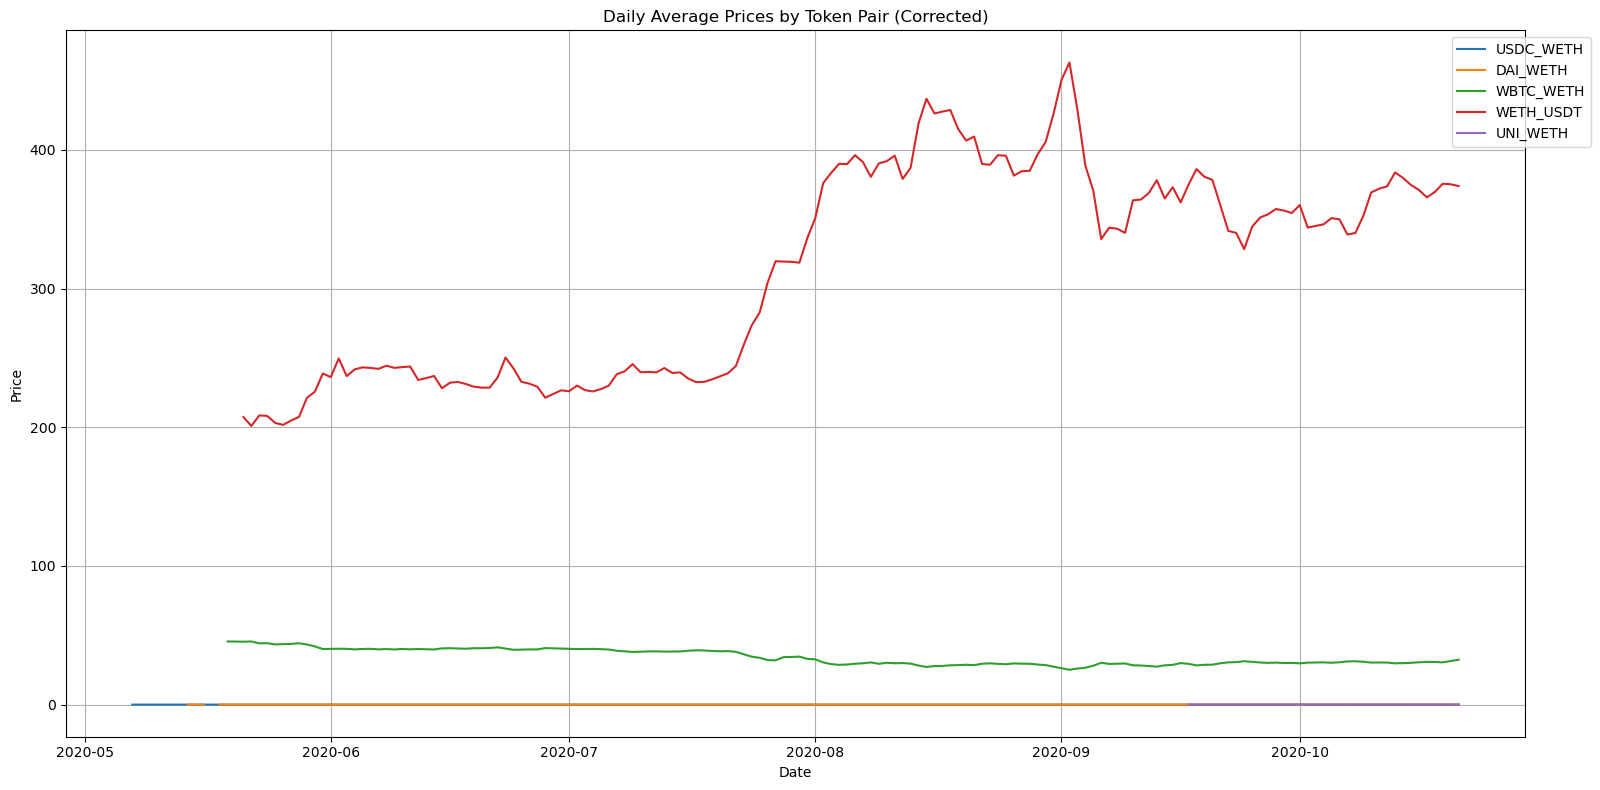

In [141]:
# Calculate price for each swap (AMOUNT1_OUT/AMOUNT0_IN)
swaps['price'] = np.where(
    swaps['AMOUNT0_IN'] > 0,
    swaps['AMOUNT1_OUT'] / swaps['AMOUNT0_IN'],
    np.nan
)


# Group by day and token pair to get daily average prices
daily_prices = swaps.groupby(['BLOCK_SIGNED_AT_DAY', 'token_pairs'])['price'].agg(['mean', 'min', 'max']).reset_index()

# Plot price trends
plt.figure(figsize=(16, 8))
for pair in swaps['token_pairs'].unique():
    pair_data = daily_prices[daily_prices['token_pairs'] == pair]
    plt.plot(pair_data['BLOCK_SIGNED_AT_DAY'], pair_data['mean'], label=pair)

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Daily Average Prices by Token Pair (Corrected)')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.grid(True)
plt.tight_layout()
plt.show()

## Part 8: Trade Size Analysis

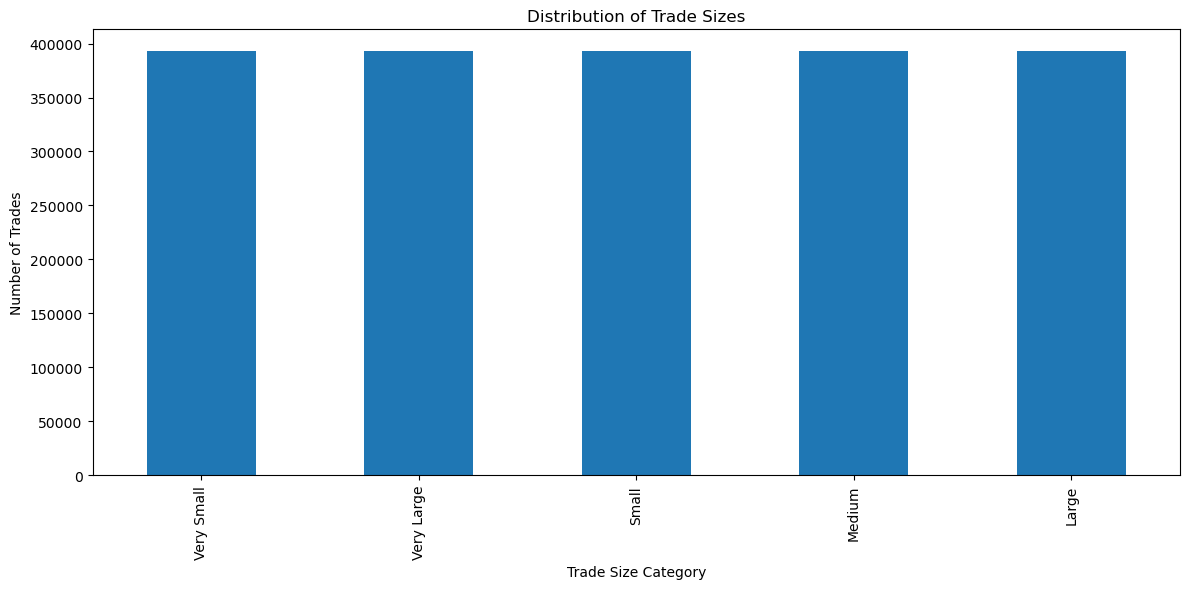

In [112]:
# Calculate trade sizes in ETH terms
swaps['trade_size_eth'] = np.where(
    swaps['TOKEN_1_TICKER_SYMBOL'] == 'ETH',
    swaps['AMOUNT1_IN'] + swaps['AMOUNT1_OUT'],
    swaps['AMOUNT0_IN'] + swaps['AMOUNT0_OUT']
)

# Create trade size categories
swaps['trade_size_category'] = pd.qcut(
    swaps['trade_size_eth'], 
    q=5, 
    labels=['Very Small', 'Small', 'Medium', 'Large', 'Very Large']
)

# Plot distribution of trade sizes
plt.figure(figsize=(12, 6))
swaps['trade_size_category'].value_counts().plot(kind='bar')
plt.title('Distribution of Trade Sizes')
plt.xlabel('Trade Size Category')
plt.ylabel('Number of Trades')
plt.tight_layout()
plt.show()

## Part 9: LP Behavior Analysis

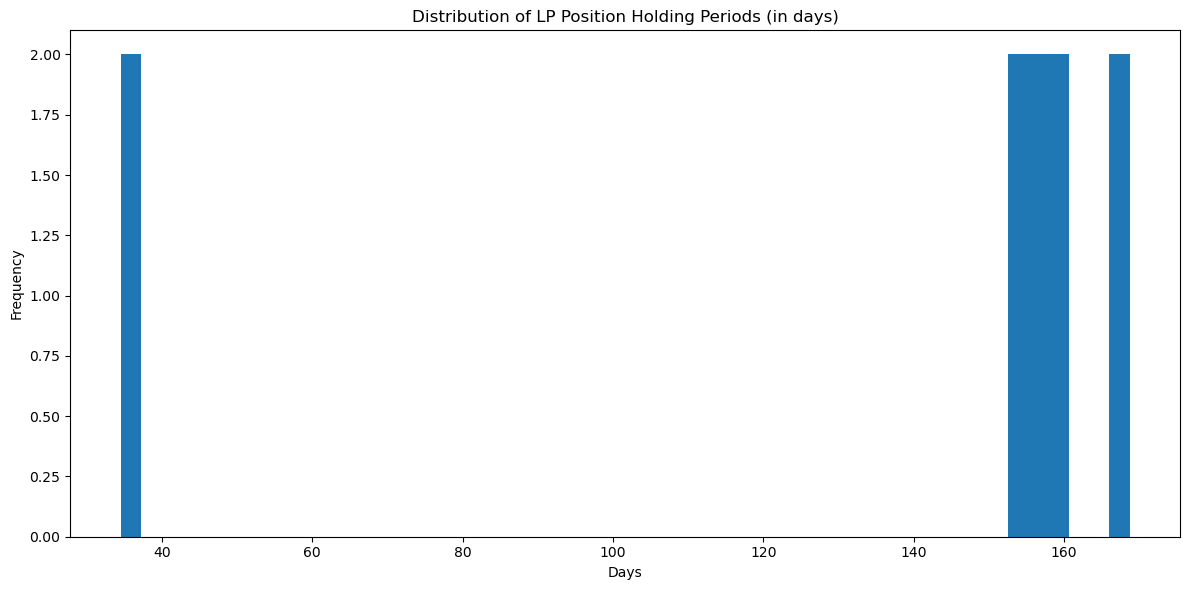

In [134]:
# Convert timestamps to datetime if not already
burn_mint['BLOCK_SIGNED_AT'] = pd.to_datetime(burn_mint['BLOCK_SIGNED_AT'])

# Group by LP address and token pairs
lp_activity = burn_mint.groupby(['POOL_ADDRESS', 'token_pairs', 'EVENT_TYPE'])\
    .agg({'BLOCK_SIGNED_AT': ['min', 'max']}).reset_index()

# Calculate time durations in days
lp_activity['duration_days'] = (lp_activity['BLOCK_SIGNED_AT']['max'] - 
                               lp_activity['BLOCK_SIGNED_AT']['min']).dt.total_seconds() / (24 * 60 * 60)

# Plot distribution of LP holding periods
plt.figure(figsize=(12, 6))
plt.hist(lp_activity['duration_days'].dropna(), bins=50)
plt.title('Distribution of LP Position Holding Periods (in days)')
plt.xlabel('Days')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


Pool Activity Summary:
--------------------
                  LOGGED_AMOUNT0                           EVENT_TYPE
                           count      mean           sum value_counts
DAI_WETH                 38121.0  40762.64  1.553913e+09          NaN
UNI_WETH                 20776.0   1526.59  3.171635e+07          NaN
USDC_WETH                27332.0  83207.91  2.274239e+09          NaN
WBTC_WETH                18416.0      6.19  1.139905e+05          NaN
WETH_USDT                39990.0    146.34  5.851949e+06          NaN
(DAI_WETH, MINT)             NaN       NaN           NaN      26449.0
(DAI_WETH, BURN)             NaN       NaN           NaN      11672.0
(UNI_WETH, MINT)             NaN       NaN           NaN      14513.0
(UNI_WETH, BURN)             NaN       NaN           NaN       6263.0
(USDC_WETH, MINT)            NaN       NaN           NaN      17663.0
(USDC_WETH, BURN)            NaN       NaN           NaN       9669.0
(WBTC_WETH, MINT)            NaN       NaN   

<Figure size 1500x700 with 0 Axes>

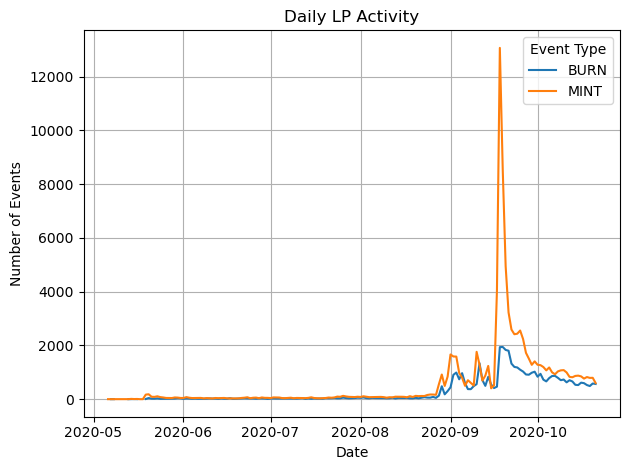

In [136]:
# Analyze LP behavior by pool
pool_summary = burn_mint.groupby('token_pairs').agg({
    'LOGGED_AMOUNT0': ['count', 'mean', 'sum'],
    'EVENT_TYPE': 'value_counts'
}).round(2)

print("\nPool Activity Summary:")
print("--------------------")
print(pool_summary)

# Plot daily LP activity
daily_activity = burn_mint.groupby(['BLOCK_SIGNED_AT_DAY', 'EVENT_TYPE']).size().unstack()
plt.figure(figsize=(15, 7))
daily_activity.plot()
plt.title('Daily LP Activity')
plt.xlabel('Date')
plt.ylabel('Number of Events')
plt.legend(title='Event Type')
plt.grid(True)
plt.tight_layout()
plt.show()

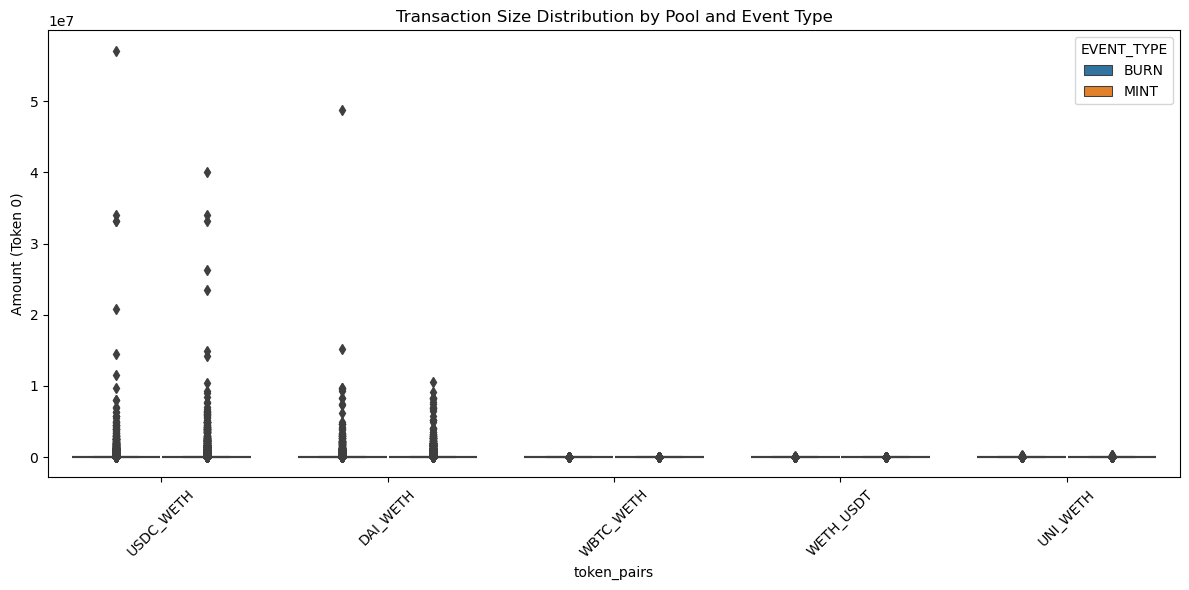


Key Insights:
-------------
Most active pair: WETH_USDT
Average daily events: 874.77
Peak daily events: 15008.00

Pool-wise Event Distribution:
EVENT_TYPE    BURN   MINT
token_pairs              
DAI_WETH     11672  26449
UNI_WETH      6263  14513
USDC_WETH     9669  17663
WBTC_WETH     5169  13247
WETH_USDT    14265  25725


In [139]:
# Add size analysis
burn_mint['transaction_size'] = pd.to_numeric(burn_mint['LOGGED_AMOUNT0'])
plt.figure(figsize=(12, 6))
sns.boxplot(x='token_pairs', y='transaction_size', hue='EVENT_TYPE', data=burn_mint)
plt.title('Transaction Size Distribution by Pool and Event Type')
plt.xticks(rotation=45)
plt.ylabel('Amount (Token 0)')
plt.tight_layout()
plt.show()

# Print insights
print("\nKey Insights:")
print("-------------")
print(f"Most active pair: {burn_mint['token_pairs'].value_counts().index[0]}")
print(f"Average daily events: {daily_activity.mean().sum():.2f}")
print(f"Peak daily events: {daily_activity.max().sum():.2f}")
print("\nPool-wise Event Distribution:")
event_dist = burn_mint.groupby('token_pairs')['EVENT_TYPE'].value_counts().unstack()
print(event_dist)

In [146]:
# Adding LP turnover analysis
burns_by_lp = burn_mint[burn_mint['EVENT_TYPE'] == 'BURN'].groupby('POOL_ADDRESS')['LOGGED_AMOUNT0'].count()
mints_by_lp = burn_mint[burn_mint['EVENT_TYPE'] == 'MINT'].groupby('POOL_ADDRESS')['LOGGED_AMOUNT0'].count()
lp_turnover = pd.DataFrame({
    'burns': burns_by_lp,
    'mints': mints_by_lp
}).fillna(0)
lp_turnover['turnover_ratio'] = lp_turnover['burns'] / lp_turnover['mints']

print("\nLP Turnover Analysis:")
print("-------------------")
print(f"Average LP Turnover Ratio: {lp_turnover['turnover_ratio'].mean():.2f}")
print(f"Most Stable Pool (lowest turnover): {lp_turnover['turnover_ratio'].idxmin()}")
print(f"Most Dynamic Pool (highest turnover): {lp_turnover['turnover_ratio'].idxmax()}")



LP Turnover Analysis:
-------------------
Average LP Turnover Ratio: 0.47
Most Stable Pool (lowest turnover): 0xbb2b8038a1640196fbe3e38816f3e67cba72d940
Most Dynamic Pool (highest turnover): 0x0d4a11d5eeaac28ec3f61d100daf4d40471f1852


## Part 10: Market Activity Patterns

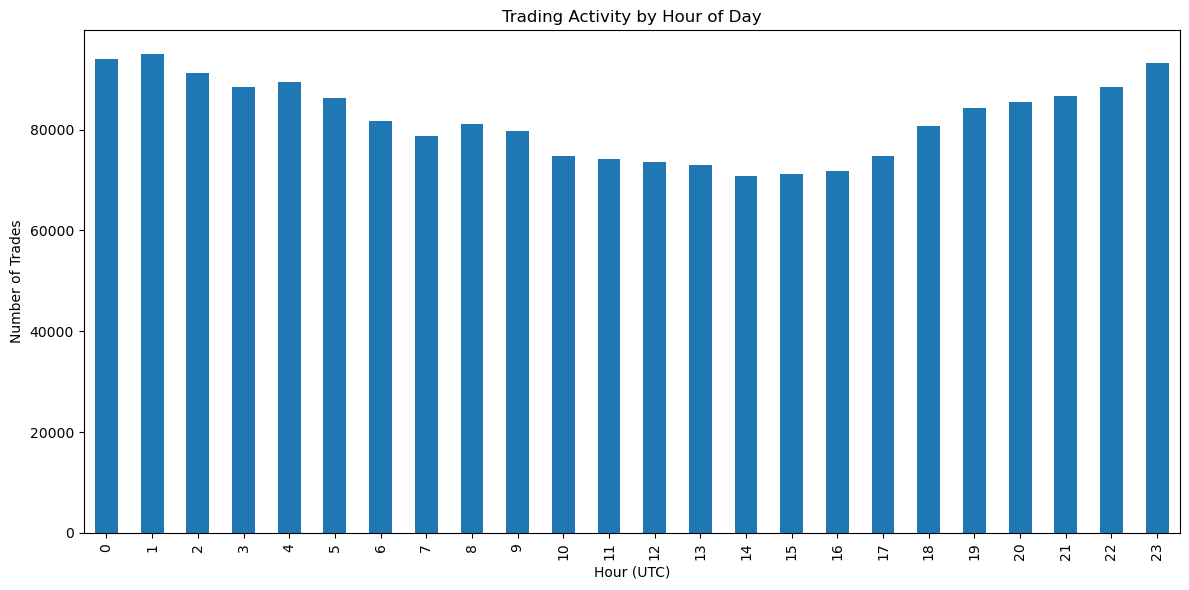

In [117]:
# Add hour of day analysis
swaps['hour'] = pd.to_datetime(swaps['BLOCK_SIGNED_AT']).dt.hour
hourly_activity = swaps.groupby('hour').size()

plt.figure(figsize=(12, 6))
hourly_activity.plot(kind='bar')
plt.title('Trading Activity by Hour of Day')
plt.xlabel('Hour (UTC)')
plt.ylabel('Number of Trades')
plt.tight_layout()
plt.show()

## Part 11: Volume-Price Correlation

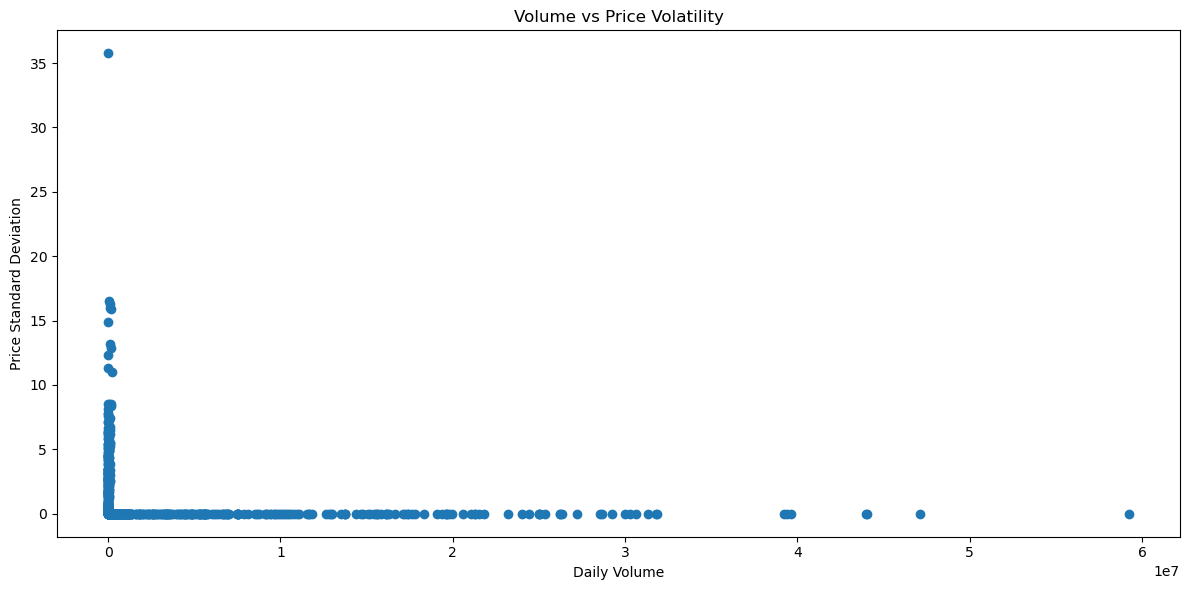

In [127]:
# Calculate daily volumes and price changes
daily_data = swaps.groupby(['BLOCK_SIGNED_AT_DAY', 'token_pairs']).agg({
    'AMOUNT0_IN': 'sum',  # Volume
    'price': ['mean', 'std']  # Price metrics
}).reset_index()

# Plot volume vs price volatility
plt.figure(figsize=(12, 6))
plt.scatter(daily_data[('AMOUNT0_IN', 'sum')], 
           daily_data[('price', 'std')])
plt.xlabel('Daily Volume')
plt.ylabel('Price Standard Deviation')
plt.title('Volume vs Price Volatility')
plt.tight_layout()
plt.show()

## Key Market Insights

In [156]:
print("\nKey Market Insights:")
print("------------------")

print(f"Total Number of Transactions: {len(swaps) + len(burn_mint):,}")
print(f"Average Daily Transactions: {daily_transactions['total'].mean():.2f}")
print(f"Maximum Daily Transactions: {daily_transactions['total'].max():.0f} transactions")
print(f"Swap to Burn/Mint ratio: {len(swaps)/len(burn_mint):.2f}")

print("\nPool Performance:")
print(f"Most Active Trading Pair: {volume_by_pair.idxmax()}")
print(f"Highest Volume Pool: {volume_by_pair.nlargest(1).index[0]} ({volume_by_pair.max():.2f} volume)")

# LP Activity
print("\nLP Activity:")
mint_count = len(burn_mint[burn_mint['EVENT_TYPE'] == 'MINT'])
burn_count = len(burn_mint[burn_mint['EVENT_TYPE'] == 'BURN'])
print(f"Total Mints: {mint_count:,}")
print(f"Total Burns: {burn_count:,}")
print(f"Mint/Burn Ratio: {mint_count/burn_count:.2f}")

print(f"\nDate Range: {daily_transactions.index.min()} to {daily_transactions.index.max()}")


Key Market Insights:
------------------
Total Number of Transactions: 2,112,137
Average Daily Transactions: 12572.24
Maximum Daily Transactions: 81974 transactions
Swap to Burn/Mint ratio: 13.60

Pool Performance:
Most Active Trading Pair: WETH_USDT
Highest Volume Pool: WETH_USDT (1704183787.06 volume)

LP Activity:
Total Mints: 97,597
Total Burns: 47,038
Mint/Burn Ratio: 2.07

Date Range: 2020-05-06 to 2020-10-21
